<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports, Parameters, Functions </span>

In [1]:
import  utils
import  pandas                                      as      pd
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
from    math                                        import  exp
from    time                                        import  time
from    tqdm                                        import  tqdm
from    scipy.stats                                 import  norm, johnsonsu, johnsonsb, lognorm, kstest
from    statsmodels.stats.diagnostic                import  normal_ad

np.random.seed(0)
plt.style.use('ggplot')

In [2]:
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'

In [3]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M_train     = 200000
M_test      = 10000
ind_delta   = int(delta/dt)
alpha       = 0.99
K           = 95

## <span id="section-1" style="color:#00B8DE"> I - Risk Factors & Portfolio Paths </span>

In [4]:
gen_riskfactors             = lambda S0, M, N: utils.gen_riskfactors(S0, r, sigma, dt, M, N)
gen_mtm                     = lambda S_paths, time_grid: utils.gen_mtm(S_paths, r, sigma, K, T, time_grid)
get_mtmdiff_nmc             = lambda M_in, S, mtm, ind_tref: utils.get_mtmdiff_nmc(M_in, S, mtm, r, sigma, dt, K, T, ind_tref, ind_delta, time_grid)
get_var_put                 = lambda S, mtm, ind_tref: utils.get_var_put(S, mtm, r, sigma, K, T, alpha, delta, ind_tref, time_grid)
percentile_matching_johnson = lambda mtm, S_train, mtm_train, ind_tref, Nnmc, z: utils.percentile_matching_johnson(mtm, S_train, mtm_train, r, sigma, dt, K, T, ind_tref, ind_delta, time_grid, Nnmc, z)

In [5]:
S_paths_train   = gen_riskfactors(S0, M_train, N)
mtm_paths_train = gen_mtm(S_paths_train, time_grid)
S_paths_test    = gen_riskfactors(S0, M_test, N)
mtm_paths_test  = gen_mtm(S_paths_test, time_grid)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))

## <span id="section-6" style="color:#00B8DE"> VI - Forward IM Profile </span>

In [6]:
def get_initial_margin_jlsmc(setting_fit, setting_var, S_paths_train, mtm_paths_train, mtm_paths_pred_list):
    start = time()
    mtmdiff_paths_train = mtm_paths_train[:, ind_delta:] - mtm_paths_train[:, :-ind_delta]
    #mtmdiff_paths_train   = utils.get_mtmdiff(mtm_paths_train, ind_delta)
    imhat_full_list     = []
    for i in range(len(mtm_paths_pred_list)):
        # imhat_full_list.append(np.zeros((mtm_paths_pred_list[i].shape[0], mtm_paths_pred_list[i].shape[1]-1)))
        imhat_full_list.append(np.zeros_like(mtm_paths_pred_list[i][:, ind_delta:]))
    for t in tqdm(range(mtmdiff_paths_train.shape[1])):
        S_train         = S_paths_train[:, t]
        mtm_train       = mtm_paths_train[:, t]
        mtm_supp        = np.quantile(mtm_train, q_all, method='inverted_cdf')

        ######################################### Johnson Fitting #########################################
        ############## Moments Matching ##############
        if setting_fit['fitting'] == 'mm':
            order_moms                                          = 4
            y_train                                             = mtmdiff_paths_train[:, t:t+1]**np.arange(1, order_moms+1)
            yhat_pred_list, _                                   = utils.regress_moms(mtm_train, y_train, [mtm_supp], setting_fit, order_moms)
            murawhat_supp                                       = yhat_pred_list[0]
            muhat_supp, maskhat_supp                            = utils.get_centred_moms(yhat_pred_list[0])
            skewhat_supp, kurthat_supp, _, _, mask_tothat_supp  = utils.get_skewkurt(muhat_supp, maskhat_supp)
            jparamshat_supp, jtypehat_supp, mask_hat_supp       = utils.moment_matching_johnson(murawhat_supp[:, 0], muhat_supp[:, 0], skewhat_supp, kurthat_supp, mask_tothat_supp, False)
            jparamshat_supp, jtypehat_supp, mtm_supp            = jparamshat_supp[mask_hat_supp], jtypehat_supp[mask_hat_supp], mtm_supp[mask_hat_supp]
        ############## Percentile Matching ##############
        else:
            jparamshat_supp, jtypehat_supp, _ = percentile_matching_johnson(mtm_supp, S_train, mtm_train, t, setting_fit['Nnmc'], setting_fit['z'])
        ######################################### Value at Risk Calculation #########################################
        quanthat_supp, mask_hat_supp_johnson    = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
        mtm_supp, quanthat_supp                 = mtm_supp[mask_hat_supp_johnson.reshape(-1)], quanthat_supp[mask_hat_supp_johnson]
        mtm_list = []
        for mtm_paths in mtm_paths_pred_list:
            mtm_list.append(mtm_paths[:, t])
        varhat_list = utils.get_var_jlsmc(mtm_supp, quanthat_supp, mtm_list, setting_var)
        for i, mtm_paths in enumerate(mtm_paths_pred_list):
            imhat_full_list[i][:, t] = np.maximum(varhat_list[i], 0)
    end = time()
    
    return imhat_full_list, end-start


def get_initial_margin_glsmc(setting_mm, mtm_paths_train, mtm_paths_pred_list):
    start = time()
    mtmdiff_paths_train = mtm_paths_train[:, ind_delta:] - mtm_paths_train[:, :-ind_delta]
    # mtmdiff_paths_train   = utils.get_mtmdiff(mtm_paths_train, ind_delta)
    imhat_full_list     = []
    for i in range(len(mtm_paths_pred_list)):
        # imhat_full_list.append(np.zeros((mtm_paths_pred_list[i].shape[0], mtm_paths_pred_list[i].shape[1]-1)))
        imhat_full_list.append(np.zeros_like(mtm_paths_pred_list[i][:, ind_delta:]))
    for t in tqdm(range(mtmdiff_paths_train.shape[1])):
        mtm_train       = mtm_paths_train[:, t]
        ######################################### Gaussian Fitting #########################################
        order_moms  = 2
        y_train     = mtmdiff_paths_train[:, t:t+1]**np.arange(1, order_moms+1)
        mtm_list = []
        for mtm_paths in mtm_paths_pred_list:
            mtm_list.append(mtm_paths[:, t])
        yhat_pred_list, _ = utils.regress_moms(mtm_train, y_train, mtm_list, setting_mm, order_moms)
        for i, mtm_paths in enumerate(mtm_paths_pred_list):
            murawhat                = yhat_pred_list[i]
            muhat, maskhat          = utils.get_centred_moms(murawhat)
            ######################################### Value at Risk Calculation #########################################
            varhat                      = np.nan * np.ones_like(mtm_list[i])
            varhat[maskhat[:, 0]]       = utils.get_quantile_normal(murawhat[maskhat[:, 0], 0], muhat[maskhat[:, 0], 0], alpha).reshape(-1)
            imhat_full_list[i][:, t]    = np.maximum(varhat, 0)
    end = time()
    return imhat_full_list, end-start


def get_initial_margin_put(S_paths_pred_list, mtm_paths_pred_list):
    start = time()
    im_full_list = []
    for i, mtm_paths in enumerate(mtm_paths_pred_list):
        mtmdiff_paths   = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
        # mtmdiff_paths   = utils.get_mtmdiff(mtm_paths, ind_delta)
        var_full        = np.zeros_like(mtmdiff_paths)
        for t in tqdm(range(mtmdiff_paths.shape[1])):
            S               = S_paths_pred_list[i][:, t]
            mtm             = mtm_paths[:, t]
            var_full[:, t]  = get_var_put(S, mtm, t)
        im_full_list.append(np.maximum(var_full, 0))
    end = time()
    return im_full_list, end-start


def get_initial_margin_nmc(Nnmc, Mnmc, S_paths_pred_list, mtm_paths_pred_list):
    start = time()
    inds_nmc        = np.linspace(0, len(time_grid[:-ind_delta])-1, num=Nnmc, dtype=int)
    im_full_list    = []
    for i, mtm_paths in enumerate(mtm_paths_pred_list):
        mtmdiff_paths   = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
        # mtmdiff_paths   = utils.get_mtmdiff(mtm_paths, ind_delta)
        count_nmc       = 0
        varhat_full_nmc = np.zeros((mtmdiff_paths.shape[0], len(inds_nmc)))
        for t in tqdm(range(mtmdiff_paths.shape[1])):
            S   = S_paths_pred_list[i][:, t]
            mtm = mtm_paths[:, t]
            if t==inds_nmc[count_nmc]:
                if t==0:
                    mtmdiff_nmc_ref = get_mtmdiff_nmc(Mnmc, S[0:1], mtm[0:1], t)
                else:
                    mtmdiff_nmc_ref             = get_mtmdiff_nmc(Mnmc, S, mtm, t)
                varhat_full_nmc[:, count_nmc]   = np.quantile(mtmdiff_nmc_ref, alpha, method='inverted_cdf', axis=1)
                count_nmc                       += 1
        im_full_list.append(np.maximum(varhat_full_nmc, 0))
    end = time()
    return inds_nmc, im_full_list, end-start

def add_zero_im(imhat):
    return np.column_stack([imhat, np.zeros((imhat.shape[0], 1))])

In [7]:
setting_fit_jlsmc_list = [
    {'id': 0, 'fitting': 'mm', 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True},
    {'id': 1, 'fitting': 'mm', 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': True},
    {'id': 2, 'fitting': 'mm', 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False},
    {'id': 3, 'fitting': 'mm', 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': False},
    {'id': 4, 'fitting': 'pm', 'Nnmc': 1000, 'z': 1},
    {'id': 5, 'fitting': 'pm', 'Nnmc': 10000, 'z': 1},
    {'id': 6, 'fitting': 'pm', 'Nnmc': 1000, 'z': 0.524},
    {'id': 7, 'fitting': 'pm', 'Nnmc': 10000, 'z': 0.524},
]

setting_var_jlsmc_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4},
    {'id': 2, 'method': 'kNN', 'n_neighbors':1},
    {'id': 3, 'method': 'kNN', 'n_neighbors':3}
]

setting_fit_glsmc_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 2, 'regress_mean': False},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 2, 'regress_mean': True},
    {'id': 2, 'method': 'GLM', 'ridge': 0, 'basis_type': 'canonical', 'order': 2, 'regress_mean': False},
    {'id': 3, 'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 4, 'regress_mean': False},
    {'id': 4, 'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 4, 'regress_mean': True},
    {'id': 5, 'method': 'GLM', 'ridge': 0, 'basis_type': 'canonical', 'order': 4, 'regress_mean': False}
]

im_list, time_put = get_initial_margin_put([S_paths_train, S_paths_test], [mtm_paths_train, mtm_paths_test])
im_train, im_test = im_list[0], im_list[1]
#im_train, im_test = add_zero_im(im_train), add_zero_im(im_test)

100%|██████████| 230/230 [00:00<00:00, 861.90it/s]


In [8]:
setting_fit_jlsmc = setting_fit_jlsmc_list[5]
setting_var_jlsmc = setting_var_jlsmc_list[3]
setting_fit_glsmc = setting_fit_glsmc_list[0]

# Nnmc, Mnmc = 2, 100000 # 100000 may be the minimum for unbiased estimates
imhat_jlsmc_list, timehat_jlsmc     = get_initial_margin_jlsmc(setting_fit_jlsmc, setting_var_jlsmc, S_paths_train, mtm_paths_train, [mtm_paths_train, mtm_paths_test])
imhat_train_jlsmc, imhat_test_jlsmc = imhat_jlsmc_list[0], imhat_jlsmc_list[1]
#imhat_train_jlsmc, imhat_test_jlsmc = add_zero_im(imhat_train_jlsmc), add_zero_im(imhat_test_jlsmc)
imhat_glsmc_list, timehat_glsmc     = get_initial_margin_glsmc(setting_fit_glsmc, mtm_paths_train, [mtm_paths_train, mtm_paths_test])
imhat_train_glsmc, imhat_test_glsmc = imhat_glsmc_list[0], imhat_glsmc_list[1]
#imhat_train_glsmc, imhat_test_glsmc = add_zero_im(imhat_train_glsmc), add_zero_im(imhat_test_glsmc)
# inds_nmc, im_nmc_list, time_nmc     = get_initial_margin_nmc(Nnmc, Mnmc, [S_paths_train, S_paths_test], [mtm_paths_train, mtm_paths_test])
# im_train_nmc, im_test_nmc           = im_nmc_list[0], im_nmc_list[1]

 93%|█████████▎| 215/230 [03:11<00:14,  1.05it/s]c:\Users\CF518AW\OneDrive - EY\Documents\STAGE\EY-Initial-Margin\least_squares_mc\utils.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  if np.arccosh(1/2*np.sqrt((1+p[i]/m[i]) * (1+p[i]/n[i]))) == 0 or m[i] == 0 or n[i] == 0 or p[i] == 0:
 93%|█████████▎| 215/230 [03:12<00:13,  1.12it/s]


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

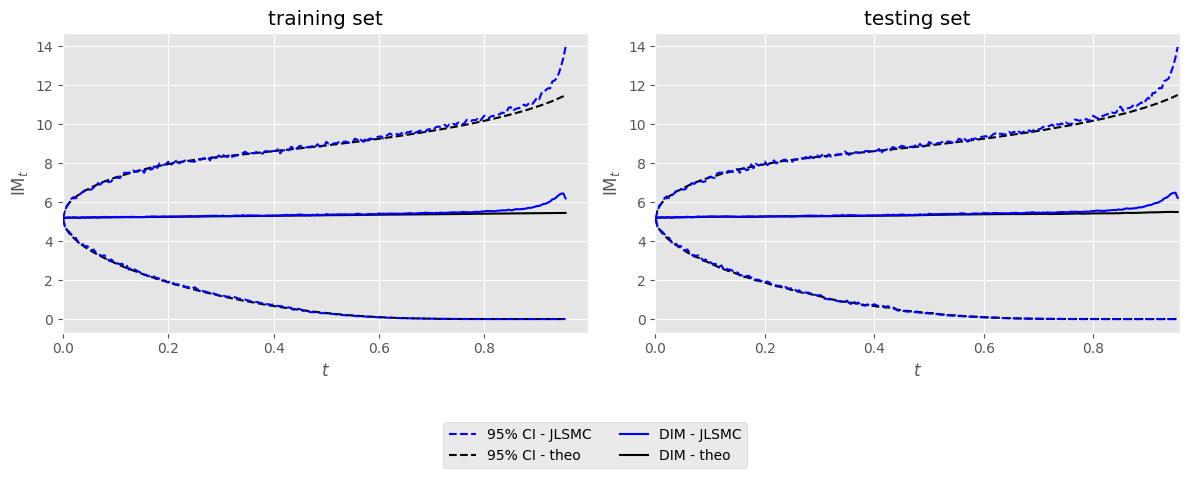

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(time_grid[:-ind_delta], np.quantile(imhat_train_jlsmc, 0.975, axis=0), linestyle='--', color=color_jlsmc, label='95% CI - JLSMC', zorder=4)
#axs[0].plot(time_grid, np.nanquantile(imhat_train_glsmc, 0.975, axis=0), linestyle='--', color=color_glsmc, label='95% CI - GLSMC', zorder=4)
#axs[0].scatter(time_grid[:-1][inds_nmc], np.quantile(im_train_nmc, 0.975, axis=0), color='black', s=30, facecolors='none', label='95% CI - NMC', clip_on=False, zorder=1)
axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
axs[0].plot(time_grid[:-ind_delta], np.mean(imhat_train_jlsmc, axis=0), color=color_jlsmc, label='DIM - JLSMC', zorder=4)
#axs[0].plot(time_grid, np.nanmean(imhat_train_glsmc, axis=0), color=color_glsmc, label='DIM - GLSMC', zorder=4)
#axs[0].scatter(time_grid[:-1][inds_nmc], np.mean(im_train_nmc, axis=0), color='black', s=30, facecolors='none', label='DIM - NMC', clip_on=False, zorder=1)
axs[0].plot(time_grid[:-ind_delta], np.mean(im_train, axis=0), color='black', label='DIM - theo', zorder=2)
axs[0].plot(time_grid[:-ind_delta], np.quantile(imhat_train_jlsmc, 0.025, axis=0), linestyle='--', color=color_jlsmc, zorder=4)
#axs[0].plot(time_grid, np.nanquantile(imhat_train_glsmc, 0.025, axis=0), linestyle='--', color=color_glsmc, zorder=4)
#axs[0].scatter(time_grid[inds_nmc], np.quantile(im_train_nmc, 0.025, axis=0), color='black', s=30, facecolors='none', clip_on=False, zorder=1)
axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.025, axis=0), linestyle='--', color='black', zorder=2)

axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$\\text{IM}_t$')
axs[0].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-1])+dt)
axs[0].set_title('training set')

axs[1].plot(time_grid[:-ind_delta], np.quantile(imhat_test_jlsmc, 0.975, axis=0), linestyle='--', color=color_jlsmc, label='95% CI - JLSMC', zorder=4)
#axs[1].plot(time_grid, np.nanquantile(imhat_test_glsmc, 0.975, axis=0), linestyle='--', color=color_glsmc, label='95% CI - GLSMC', zorder=4)
# axs[1].scatter(time_grid[:-1][inds_nmc], np.quantile(im_test_nmc, 0.975, axis=0), color='black', s=30, facecolors='none', label='95% CI - NMC', clip_on=False, zorder=1)
axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
axs[1].plot(time_grid[:-ind_delta], np.mean(imhat_test_jlsmc, axis=0), color=color_jlsmc, label='DIM - JLSMC', zorder=4)
#axs[1].plot(time_grid, np.nanmean(imhat_test_glsmc, axis=0), color=color_glsmc, label='DIM - GLSMC', zorder=4)
# axs[1].scatter(time_grid[:-1][inds_nmc], np.mean(im_test_nmc, axis=0), color='black', s=30, facecolors='none', label='DIM - NMC', clip_on=False, zorder=1)
axs[1].plot(time_grid[:-ind_delta], np.mean(im_test, axis=0), color='black', label='DIM - theo', zorder=2)
axs[1].plot(time_grid[:-ind_delta], np.quantile(imhat_test_jlsmc, 0.025, axis=0), linestyle='--', color=color_jlsmc, zorder=4)
#axs[1].plot(time_grid, np.nanquantile(imhat_test_glsmc, 0.025, axis=0), linestyle='--', color=color_glsmc, zorder=4)
# axs[1].scatter(time_grid[:-1][inds_nmc], np.quantile(im_test_nmc, 0.025, axis=0), color='black', s=30, facecolors='none', clip_on=False, zorder=1)
axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.025, axis=0), linestyle='--', color='black', zorder=2)

axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$\\text{IM}_t$')
axs[1].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
axs[1].set_title('testing set')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
plt.show()

In [ ]:
'''
list_total_time_jlsmc = []
list_mse_train_jlsmc  = []
list_mse_test_jlsmc   = []
list_index_jlsmc      = []
for setting_fit in setting_fit_jlsmc_list:
    for setting_var in setting_var_jlsmc_list:
        list_index_jlsmc.append(f'{setting_fit["id"]}_{setting_var["id"]}')
        imhat_list, timehat     = get_initial_margin_jlsmc(setting_fit, setting_var, S_paths_train, mtm_paths_train, [mtm_paths_train, mtm_paths_test])
        list_total_time_jlsmc.append(timehat)
        imhat_train, imhat_test = imhat_list[0], imhat_list[1]
        list_mse_train_jlsmc.append(np.mean((imhat_train - im_train)**2))
        list_mse_test_jlsmc.append(np.mean((imhat_test - im_test)**2))

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[0].plot(time_grid[:-ind_delta], np.quantile(imhat_train, 0.975, axis=0), linestyle='--', color=color_jlsmc, label='95% CI - JLSMC', zorder=4)
        axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
        axs[0].plot(time_grid[:-ind_delta], np.mean(imhat_train, axis=0), color=color_jlsmc, label='DIM - JLSMC', zorder=4)
        axs[0].plot(time_grid[:-ind_delta], np.mean(im_train, axis=0), color='black', label='DIM - theo', zorder=2)
        axs[0].plot(time_grid[:-ind_delta], np.quantile(imhat_train, 0.025, axis=0), linestyle='--', color=color_jlsmc, zorder=4)
        axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.025, axis=0), linestyle='--', color='black', zorder=2)

        axs[0].set_xlabel('$t$')
        axs[0].set_ylabel('$\\text{IM}_t$')
        axs[0].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
        axs[0].set_title('training set')

        axs[1].plot(time_grid[:-ind_delta], np.quantile(imhat_test, 0.975, axis=0), linestyle='--', color=color_jlsmc, label='95% CI - JLSMC', zorder=4)
        axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
        axs[1].plot(time_grid[:-ind_delta], np.mean(imhat_test, axis=0), color=color_jlsmc, label='DIM - JLSMC', zorder=4)
        axs[1].plot(time_grid[:-ind_delta], np.mean(im_test, axis=0), color='black', label='DIM - theo', zorder=2)
        axs[1].plot(time_grid[:-ind_delta], np.quantile(imhat_test, 0.025, axis=0), linestyle='--', color=color_jlsmc, zorder=4)
        axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.025, axis=0), linestyle='--', color='black', zorder=2)

        axs[1].set_xlabel('$t$')
        axs[1].set_ylabel('$\\text{IM}_t$')
        axs[1].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
        axs[1].set_title('testing set')

        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))
        plt.tight_layout()
        plt.savefig(f'figures/im_profile/jlsmc_{setting_fit["id"]}_{setting_var["id"]}.png', dpi=300, bbox_inches='tight')


df_jlsmc = pd.DataFrame({
    'total time': list_total_time_jlsmc,
    'mse train': list_mse_train_jlsmc,
    'mse test': list_mse_test_jlsmc
}, index=list_index_jlsmc)

df_jlsmc.to_csv('results/im_jlsmc.csv')
'''

'\nlist_total_time_jlsmc = []\nlist_mse_train_jlsmc  = []\nlist_mse_test_jlsmc   = []\nlist_index_jlsmc      = []\nfor setting_fit in setting_fit_jlsmc_list:\n    for setting_var in setting_var_jlsmc_list:\n        list_index_jlsmc.append(f\'{setting_fit["id"]}_{setting_var["id"]}\')\n        imhat_list, timehat     = get_initial_margin_jlsmc(setting_fit, setting_var, S_paths_train, mtm_paths_train, [mtm_paths_train, mtm_paths_test])\n        list_total_time_jlsmc.append(timehat)\n        imhat_train, imhat_test = imhat_list[0], imhat_list[1]\n        list_mse_train_jlsmc.append(np.mean((imhat_train - im_train)**2))\n        list_mse_test_jlsmc.append(np.mean((imhat_test - im_test)**2))\n\n        fig, axs = plt.subplots(1, 2, figsize=(12, 4))\n        axs[0].plot(time_grid[:-ind_delta], np.quantile(imhat_train, 0.975, axis=0), linestyle=\'--\', color=color_jlsmc, label=\'95% CI - JLSMC\', zorder=4)\n        axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.975, axis=0), line

In [ ]:
'''
list_total_time_glsmc = []
list_mse_train_glsmc  = []
list_mse_test_glsmc   = []
list_index_glsmc      = []
for setting_fit in setting_fit_glsmc_list:
    list_index_glsmc.append(f'{setting_fit["id"]}')
    imhat_list, timehat     = get_initial_margin_glsmc(setting_fit, mtm_paths_train, [mtm_paths_train, mtm_paths_test])
    list_total_time_glsmc.append(timehat)
    imhat_train, imhat_test = imhat_list[0], imhat_list[1]
    list_mse_train_glsmc.append(np.nanmean((imhat_train - im_train)**2))
    list_mse_test_glsmc.append(np.nanmean((imhat_test - im_test)**2))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(time_grid[:-ind_delta], np.nanquantile(imhat_train, 0.975, axis=0), linestyle='--', color=color_glsmc, label='95% CI - GLSMC', zorder=4)
    axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
    axs[0].plot(time_grid[:-ind_delta], np.nanmean(imhat_train, axis=0), color=color_glsmc, label='DIM - GLSMC', zorder=4)
    axs[0].plot(time_grid[:-ind_delta], np.mean(im_train, axis=0), color='black', label='DIM - theo', zorder=2)
    axs[0].plot(time_grid[:-ind_delta], np.nanquantile(imhat_train, 0.025, axis=0), linestyle='--', color=color_glsmc, zorder=4)
    axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.025, axis=0), linestyle='--', color='black', zorder=2)

    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('$\\text{IM}_t$')
    axs[0].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
    axs[0].set_title('training set')

    axs[1].plot(time_grid[:-ind_delta], np.nanquantile(imhat_test, 0.975, axis=0), linestyle='--', color=color_glsmc, label='95% CI - GLSMC', zorder=4)
    axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)
    axs[1].plot(time_grid[:-ind_delta], np.nanmean(imhat_test, axis=0), color=color_glsmc, label='DIM - GLSMC', zorder=4)
    axs[1].plot(time_grid[:-ind_delta], np.mean(im_test, axis=0), color='black', label='DIM - theo', zorder=2)
    axs[1].plot(time_grid[:-ind_delta], np.nanquantile(imhat_test, 0.025, axis=0), linestyle='--', color=color_glsmc, zorder=4)
    axs[1].plot(time_grid[:-ind_delta], np.quantile(im_test, 0.025, axis=0), linestyle='--', color='black', zorder=2)

    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('$\\text{IM}_t$')
    axs[1].set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
    axs[1].set_title('testing set')

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))
    plt.tight_layout()
    plt.savefig(f'figures/im_profile/glsmc_{setting_fit["id"]}.png', dpi=300, bbox_inches='tight')

df_glsmc = pd.DataFrame({
    'total time': list_total_time_glsmc,
    'mse train': list_mse_train_glsmc,
    'mse test': list_mse_test_glsmc
}, index=list_index_glsmc)

df_glsmc.to_csv('results/im_glsmc.csv')
'''

'\nlist_total_time_glsmc = []\nlist_mse_train_glsmc  = []\nlist_mse_test_glsmc   = []\nlist_index_glsmc      = []\nfor setting_fit in setting_fit_glsmc_list:\n    list_index_glsmc.append(f\'{setting_fit["id"]}\')\n    imhat_list, timehat     = get_initial_margin_glsmc(setting_fit, mtm_paths_train, [mtm_paths_train, mtm_paths_test])\n    list_total_time_glsmc.append(timehat)\n    imhat_train, imhat_test = imhat_list[0], imhat_list[1]\n    list_mse_train_glsmc.append(np.nanmean((imhat_train - im_train)**2))\n    list_mse_test_glsmc.append(np.nanmean((imhat_test - im_test)**2))\n\n    fig, axs = plt.subplots(1, 2, figsize=(12, 4))\n    axs[0].plot(time_grid[:-ind_delta], np.nanquantile(imhat_train, 0.975, axis=0), linestyle=\'--\', color=color_glsmc, label=\'95% CI - GLSMC\', zorder=4)\n    axs[0].plot(time_grid[:-ind_delta], np.quantile(im_train, 0.975, axis=0), linestyle=\'--\', color=\'black\', label=\'95% CI - theo\', zorder=2)\n    axs[0].plot(time_grid[:-ind_delta], np.nanmean(imhat